# Summer Hockey

My sister-in-law asked me to help her set up a summer hockey league
that has twenty players who will play for thirteen weeks.  Every week
the twenty players will be divided into two teams of ten. Since the
players all play for the same club in the winter and they all have
\"home\" and \"away\" jerseys, we'll assign the players to \"home\"
and \"away\" teams. Players can be assigned to teams without regard to
position. The goal is to make the assignments to minimize the number
of weeks that any pair of players is assigned to the same (or
opposing) teams.

My first thought was to assign players systematically. Given that $2^4
< 20 < 2^5$ we know that we need to have a least five games before we
can guarantee that no pair of players is on the same team every
week. However, in any five-week period, there will be at two (or more)
pairs of players who play together (or opposite) for four weeks.,

I abandoned a systematic approach in favor of random assignment.

If you generate two schedules randomly, you need a way to compare
them; that is a metric. The value of the metric tells you whether and
which one is better (in our case a lower value will be better). You
can save the better one as your \"best candidate,\" generate a new
schedule, and compare it to the current \"best candidate\". If the new
one is better, promote it to \"best candidate,\" otherwise repeat the
procedure.  Execute this process in a loop for a predetermined number
of times.
    
When I say \"generate a new schedule\", there are at least two ways to
do it. You could generate an entirely new schedule with each pass
through the loop, or you could generate a new schedule based on a
previous one. For example, replace one week in the best candidate
schedule with the new week and see if that is an improvement. The new
week in the schedule could be randomly generated or there may be a way
to \"tweak\" the schedule to improve it.  Generating a completely new
schedule is simpler to code, but the improving an existing schedule
might be faster. However, tweaking an existing schedule carries the
risk of leading to a local minimum.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

We need some preliminary ideas about what team assignments look like.  Let's assign players to teams using 1 for "home" and -1 for "away."  With twenty players and thirteen weeks, we will need a 13x20 array to represent a full season schedule where each row consists of ten 1's and ten -1's. If we start with one such row, we can generate another simply by "shuffling" the numbers.

In [2]:
from numpy.random import shuffle

# Here is one weekly assignment. 
assignment = 2*(np.arange(20) % 2) - 1
print(assignment)
# Here we shuffle the assignment. Note how the vector is changed. 
shuffle(assignment)
print(assignment)

[-1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1]
[ 1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1  1 -1 -1  1]


We generate a season by initializing a matrix with zeros. The first weekly assignment will just be the alternating 1s and -1s, and we shuffle this 20-element array 12 times.

In [3]:
league = np.zeros((13,20),int)
assignment = 2*(np.arange(20) % 2) - 1
for i in range(13):
    league[i] = assignment
    shuffle(assignment)
print(league)

[[-1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1]
 [ 1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1  1  1 -1 -1  1]
 [-1  1 -1  1 -1 -1 -1  1  1  1  1 -1  1 -1 -1  1  1 -1  1 -1]
 [-1 -1  1  1 -1 -1  1 -1  1  1  1  1  1 -1 -1  1 -1  1 -1 -1]
 [-1 -1  1 -1  1 -1 -1  1 -1  1  1 -1  1 -1 -1  1  1 -1  1  1]
 [ 1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1  1  1  1  1]
 [-1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1  1 -1  1  1  1 -1  1  1]
 [ 1 -1  1  1 -1  1 -1  1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1]
 [-1  1  1  1 -1 -1  1  1 -1  1 -1 -1  1  1 -1 -1 -1  1  1 -1]
 [-1  1  1 -1  1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1  1]
 [-1  1 -1  1  1  1  1  1  1 -1  1 -1 -1  1 -1  1 -1 -1 -1 -1]
 [-1 -1  1 -1  1 -1 -1 -1 -1 -1  1  1  1  1 -1  1  1 -1  1  1]
 [ 1 -1  1  1 -1  1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1  1  1]]


The j-th column `league[:,j]` represents the assignments for player `j`.

In [4]:
j = np.random.randint(20)
print(f'Player {j} has assignments {league[:,j]}')

Player 11 has assignments [ 1  1 -1  1 -1 -1  1  1 -1 -1 -1  1 -1]


Notice that if you take the inner product (or dot product) between two columns you get a number between -13 an +13 which is the difference between the number of weeks that two players play together and number that they are opposed. For example, if player `i` and `j` play together 8 times and opposed 5 times, then `league[:,i].transpose() @ league[:,j]` will be 3; i.e. 8-5.

In [5]:
i = np.random.randint(20)
print(f'Player {i} has assignments {league[:,i]}')

j = i
while i==j:
    j = np.random.randint(20)
print(f'Player {j} has assignments {league[:,j]}')

print(f'Same - Opposing = {league[:,i].transpose() @ league[:,j]}')

Player 3 has assignments [ 1 -1  1  1 -1 -1 -1  1  1 -1  1 -1  1]
Player 11 has assignments [ 1  1 -1  1 -1 -1  1  1 -1 -1 -1  1 -1]
Same - Opposing = -1


This means that if we take the matrix product `league.transpose() @ league`, the `ij` entry will be `league[:,i].transpose() @ league[:,j]` which encodes the same-minus-opposing count for players `i` and `j`.  Note that the product matrix `league.transpose() @ league` is a 13x13 square matrix whose diagonal elements are all 13 with all off-diagonal entries between -13 and 13. Because there are an odd number of games, all off-diagonal elements are odd numbers.  

In [6]:
print(league.transpose() @ league)

[[ 13  -5   3  -1  -5   3  -1  -1   1  -7  -3   1  -1   1   5  -7  -1   3
   -1   3]
 [ -5  13  -7   1   1   1   1   1  -1   3  -1  -1  -3   3  -1   3   1  -3
   -3  -3]
 [  3  -7  13  -3  -3  -3   1  -3  -5  -1   3  -1   5  -1  -5  -1   1   1
    1   5]
 [ -1   1  -3  13  -7   5   5   9   3  -1  -1  -1   1  -1  -5  -1 -11   5
   -3  -7]
 [ -5   1  -3  -7  13   1   1  -3  -1  -1   3  -1  -3  -1   3   3   5  -7
    1   1]
 [  3   1  -3   5   1  13   5   5  -1  -5  -1  -1  -7  -1  -1  -1  -7   1
   -7   1]
 [ -1   1   1   5   1   5  13   1   3  -1  -1  -5  -3  -1  -1  -5  -7   5
   -3  -7]
 [ -1   1  -3   9  -3   5   1  13  -1  -1  -1  -5   1  -1  -5  -1  -7   1
    1  -3]
 [  1  -1  -5   3  -1  -1   3  -1  13   1   1  -3  -5   1   5  -3  -1   3
   -1  -9]
 [ -7   3  -1  -1  -1  -5  -1  -1   1  13  -3  -3  -1  -3   1   1   3   3
    3  -1]
 [ -3  -1   3  -1   3  -1  -1  -1   1  -3  13   1   3  -3  -7   9   3  -9
   -5  -1]
 [  1  -1  -1  -1  -1  -1  -5  -5  -3  -3   1  13   3   1   1   5

However, if `league` represents a good season schedule, the off-diagonal elements will be close to zero (a perfect schedule would have all +/-1).  There are two natural ways to measure "goodness." Let `my_diag` be a 13x13 diagonal matrix with all 13s on the diagonal.

In [7]:
my_diag = np.zeros((20,20),int)
np.fill_diagonal(my_diag,13)
print(my_diag)

[[13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0

We can measure if `league.transpose @ league` is close to `my_diag` using the Frobenius norm, also called the $L^2$ norm, which is just the sum of squares. Here is the Frobenius norm of a matrix $A$:
$$
\|A\|_F = \left(\sum a_{ij}^2\right)^{1/2}
$$
See the [Numpy documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).

In [8]:
# Frobenius norm is the default of the np.linalg.norm, but we make it explicit here:
def frob_norm(matrix):
    return norm(matrix,ord='fro')
frob_norm(league.transpose()@league - my_diag)

71.97221686178632

The other is to take the maximum of the absolute value of all elements in the difference of the two matrices; i.e. `np.max(np.abs(league.transpose @ league - my_diag))`. Taking the `max` of the `abs` of the entries is the same as the $L^\infty$ norm for a vector which is *not* the same as a $L^\infty$ norm of a matrix. We can use the `norm` function again, but we have to `flatten` the matrix to one dimension.  See the [Numpy documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).

In [9]:
def inf_norm(matrix):
    return norm(matrix.flatten(),ord=np.inf)
inf_norm((league.transpose()@league - my_diag))

11.0

Note that when the `inf_norm((league.transpose()@league - my_diag))` is k, then there is some pair of players who are assigned to the same (or opposing) team (k+13)/2 times; e.g. when k=9, then (9+13)/2 = 11. 

We seek a matrix `league` such that `inf_norm(league.transpose() @ league - my_diag)` and `frob_norm(league.transpose() @ league - my_diag)` are both *minimized.*   Since `inf_norm` is integer valued. One can imagine that there would be two matrices representing a full season `league1` and `league2` where the `inf_norm`s are equal, but the `frob_norm`s are *not.* So we consider `league2` superior to `league1` if the `inf_norm` is smaller OR if the `inf_norm` is no larger and the `forb_norm` is smaller.

In [10]:
frob_norm_min = 13*20
inf_norm_min = 13

max_iter = 100000
max_width = int(np.ceil(np.log10(max_iter)))
            
for trial in range(max_iter):
    assignment = 2*(np.arange(20) % 2) - 1
    league = np.zeros((13,20),int)
    for i in range(13):
        # make sure that the new assignment is different from any previous.
        while np.max(league @ assignment.transpose()) == 20:
            shuffle(assignment)
        league[i] = assignment
        shuffle(assignment)

    frob_norm_ = frob_norm(league.transpose() @ league - my_diag)
    inf_norm_ = inf_norm(league.transpose() @ league - my_diag)
    if ((inf_norm_ < inf_norm_min) or 
        ((inf_norm_ <= inf_norm_min) and (frob_norm_ < frob_norm_min))):
        inf_norm_min = inf_norm_
        frob_norm_min = frob_norm_
        best_league = league.copy()
        print(f'Trial {trial:{max_width}d}: frob_norm_min={frob_norm_min:.3f}, inf_norm_min={inf_norm_min}')


Trial     0: frob_norm_min=74.162, inf_norm_min=9.0
Trial     1: frob_norm_min=67.853, inf_norm_min=9.0
Trial     3: frob_norm_min=67.142, inf_norm_min=9.0
Trial    21: frob_norm_min=66.903, inf_norm_min=9.0
Trial    55: frob_norm_min=65.696, inf_norm_min=9.0
Trial    79: frob_norm_min=64.218, inf_norm_min=9.0
Trial   375: frob_norm_min=72.636, inf_norm_min=7.0
Trial   436: frob_norm_min=65.939, inf_norm_min=7.0
Trial   543: frob_norm_min=65.207, inf_norm_min=7.0
Trial   578: frob_norm_min=63.214, inf_norm_min=7.0
Trial   725: frob_norm_min=62.450, inf_norm_min=7.0
Trial  1139: frob_norm_min=61.935, inf_norm_min=7.0
Trial 11184: frob_norm_min=61.677, inf_norm_min=7.0
Trial 11306: frob_norm_min=61.156, inf_norm_min=7.0
Trial 38003: frob_norm_min=60.100, inf_norm_min=7.0
Trial 80191: frob_norm_min=57.931, inf_norm_min=7.0


One question remains: Through how many iterations should we run? There are a lot of weekly assignments; specifically, `scipy.special.binom(20,10)/2` is over 90,000. The number of possible 13-week season schedules over 5e+54.  Although above, I have only run for 100 iterations, I ran 5 million iterations.  The `inf_norm` was sometimes achieved early but was never lower than 7. And the minimum Forbenius norm was updated as deep into the loop as 2.5 million iterations.

In [11]:
from scipy.special import binom
print(binom(20,10)/2)
print(binom(binom(20,10)/2,13))

92378.0
5.7245873760035234e+54


Finally, we also want the 'Home' and 'Away' assignments to be relatively uniform too. The quantity `np.sum((best_league + 1)//2,axis=0)` yields a 20 element vector with the j-th element representing the number of times player j is on the 'Home' team. We would like this vector to be close to 6.5 in each entry. One way to ensure this is to minimize standard deviation of the elements. If we can take a single week -- a row of the matrix `league` -- switching the 'Home' and 'Away' assignments only requires us to multiply by -1. If this decreases the standard deviation of the home assignments, then that would be a better league.

In [12]:
home_team = np.sum((best_league + 1)//2,axis=0)
home_team_std_min = np.std(home_team)
print(f'Home team std: {home_team_std_min:.4f}')


# I have seen better Home assignments after two loops, not more.
for i in range(3):
    for k in range(13):
        league = best_league.copy()
        league[k,:] = -league[k,:]
        home_team = np.sum((league + 1)//2,axis=0)
        home_team_std = np.std(home_team)
        if home_team_std < home_team_std_min:
            best_league = league
            home_team_std_min = home_team_std
            print(f'Run {i}, Trial {k}: {home_team_std_min:.4f}')

print(home_team)
print(home_team_std_min)

Home team std: 1.7464
Run 0, Trial 0: 1.5652
Run 0, Trial 1: 1.5000
Run 0, Trial 3: 1.4318
[9 7 8 8 7 5 6 5 8 5 8 5 4 5 8 7 4 6 7 8]
1.4317821063276353


What is the range of same-team assignments?

In [13]:
same = (best_league.transpose() @ best_league + np.ones((20,20),int)*13)//2
np.min(same), np.max(same - my_diag)

(3, 10)

In [14]:
print(same - my_diag)

[[ 0  7  6  8  5  7  6  5  8  5  6  5  6  7  6  9  6  6  5  4]
 [ 7  0  4  8  7  7  8  5  6  7  6  7  4  5  6  7  8  4  5  6]
 [ 6  4  0  3  4  6  5  6  7  8  9 10  5  6  7  6  5  7  6  7]
 [ 8  8  3  0  8  6  5  4  7  6  3  6  5  8  5  8  5  7  8  7]
 [ 5  7  4  8  0  5  8  5  8  5  6  5  8  7  8  3  6  4  7  8]
 [ 7  7  6  6  5  0  6  5  4  7  6  7  4  5  8  7  8  6  7  6]
 [ 6  8  5  5  8  6  0  8  7  4  7  4  7  6  7  6  9  3  6  5]
 [ 5  5  6  4  5  5  8  0  8  7  8  5  8  7  4  7  6  8  5  6]
 [ 8  6  7  7  8  4  7  8  0  6  7  6  5  8  5  6  5  5  6  3]
 [ 5  7  8  6  5  7  4  7  6  0  6  9  6  5  4  9  4  6  7  6]
 [ 6  6  9  3  6  6  7  8  7  6  0  6  7  6  7  4  7  5  4  7]
 [ 5  7 10  6  5  7  4  5  6  9  6  0  4  7  4  5  6  8  5  8]
 [ 6  4  5  5  8  4  7  8  5  6  7  4  0  8  7  6  7  7  6  7]
 [ 7  5  6  8  7  5  6  7  8  5  6  7  8  0  6  7  4  6  3  6]
 [ 6  6  7  5  8  8  7  4  5  4  7  4  7  6  0  6  7  5  8  7]
 [ 9  7  6  8  3  7  6  7  6  9  4  5  6  7  6  0  4  6

Here we see the distribution of same-team assignments between pairs of players. It should be concentrated on 6 and 7.

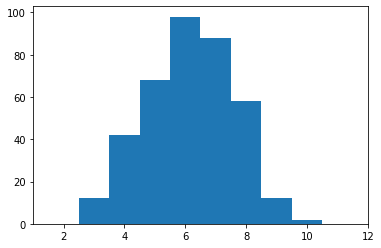

In [15]:
plt.hist(same.flatten(),bins=np.linspace(1.5,11.5,11));

### Output
We put the data into a DataFrame, transform it to text, and print to CSV file.

In [16]:
players = [f'Player_{j:02d}' for j in range(1,21)]
weeks = [f'Week_{j:02d}' for j in range(1,14)]
df_league_num = pd.DataFrame(best_league,columns=players,index=weeks)

In [17]:
df_league = pd.concat([df_league_num[col].apply(lambda x: 'Home' if x == 1 else 'Away') for col in df_league_num.columns],axis=1)

In [18]:
df_league

,Player_01,Player_02,Player_03,Player_04,Player_05,Player_06,Player_07,Player_08,Player_09,Player_10,Player_11,Player_12,Player_13,Player_14,Player_15,Player_16,Player_17,Player_18,Player_19,Player_20
Week_01,Home,Away,Home,Away,Home,Away,Home,Away,Home,Away,Home,Away,Home,Away,Home,Away,Home,Away,Home,Away
Week_02,Away,Home,Home,Away,Home,Away,Home,Home,Home,Home,Home,Home,Away,Away,Away,Away,Away,Away,Away,Home
Week_03,Home,Away,Home,Home,Away,Home,Away,Away,Away,Home,Away,Home,Away,Away,Away,Home,Away,Home,Home,Home
Week_04,Home,Away,Home,Away,Away,Home,Home,Home,Home,Away,Home,Away,Away,Home,Home,Home,Away,Away,Away,Away
Week_05,Home,Home,Home,Home,Away,Away,Away,Away,Home,Home,Home,Home,Away,Home,Away,Home,Away,Away,Away,Away
Week_06,Away,Away,Home,Away,Away,Away,Away,Home,Away,Home,Home,Away,Home,Away,Home,Home,Away,Home,Home,Home
Week_07,Home,Home,Home,Away,Away,Home,Away,Away,Away,Away,Home,Home,Away,Away,Home,Away,Home,Home,Away,Home
Week_08,Home,Home,Away,Home,Away,Away,Home,Home,Home,Away,Away,Away,Away,Away,Away,Home,Home,Home,Home,Away
Week_09,Home,Away,Away,Home,Home,Away,Away,Home,Home,Away,Home,Away,Home,Home,Away,Away,Away,Home,Away,Home
Week_10,Home,Home,Away,Home,Home,Away,Home,Away,Away,Away,Away,Away,Home,Home,Home,Home,Away,Away,Away,Home


In [19]:
# df_league.to_excel('Summer_League.xlsx')